<a href="https://colab.research.google.com/github/ishitadatta/S-P-stock-analysis/blob/master/ExponentialSmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import plotly.graph_objects as go
from plotly.offline import iplot
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import datetime
from datetime import timedelta
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima 
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools  import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing, HoltWintersResults
import warnings
warnings.filterwarnings('ignore') 
# from pyearth import Earth

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.1MB/s 
     |████████████████████████████████| 2.1MB 24.0MB/s 
     |████████████████████████████████| 808kB 29.6MB/s 
     |████████████████████████████████| 8.7MB 29.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
stock_list = ['AAPL', 'AMZN', 'FB', 'GOOGL', 'MSFT']

# for stock in stock_list:                                                           # Include this loop when you are running 
#     df = pd.read_csv(stock + '_data.csv', index_col='date')  # the script for all stocks in .py file

df1 = pd.read_csv('all_stocks_5yr.csv', index_col='date')            # Delete this line when running the loop

In [ ]:
df = df1[df1['Name'] == 'AAPL'] 

In [ ]:
df.index = pd.to_datetime(df.index)                               # Converts the index i.e.date into datetime format

In [ ]:
df.drop(columns = ["open", "high", "low", "volume", "Name"], inplace=True)   # Deletes all columns other than date and close

In [ ]:
fig = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": df.index,
            "y": df.close,
            "name": "AAPL",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        }
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [df.index[len(df) - 261], df.index[len(df) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 500,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(fig)

In [ ]:
df_copy=df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [ ]:
df = df.resample('D').ffill()                      # Fills in missing dates like weekends to get a continuous frequency data

In [ ]:
total = df.isnull().sum().sort_values()                                              #counts all null cells in a row
percent = ((df.isnull().sum()/df.isnull().count()).sort_values()*100)                #sees what percent of the data is null
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])            #combines the two matrixies
missing_data  

,Total,Percent
close,0,0.0


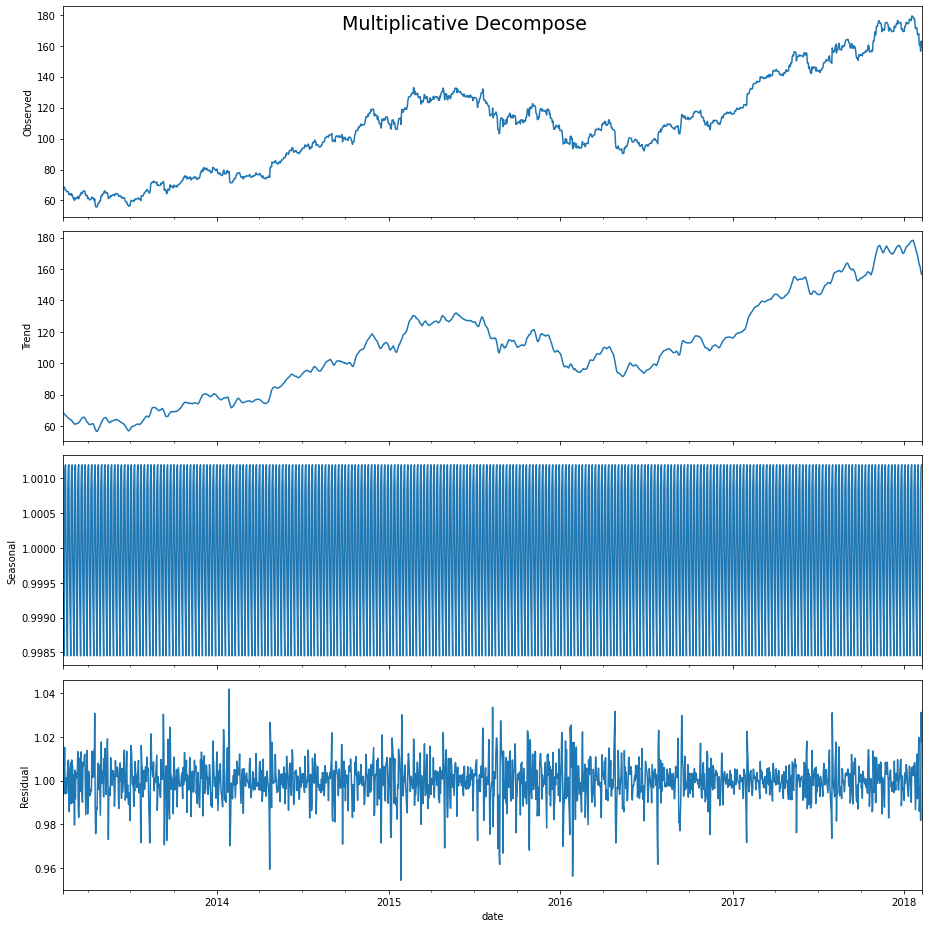

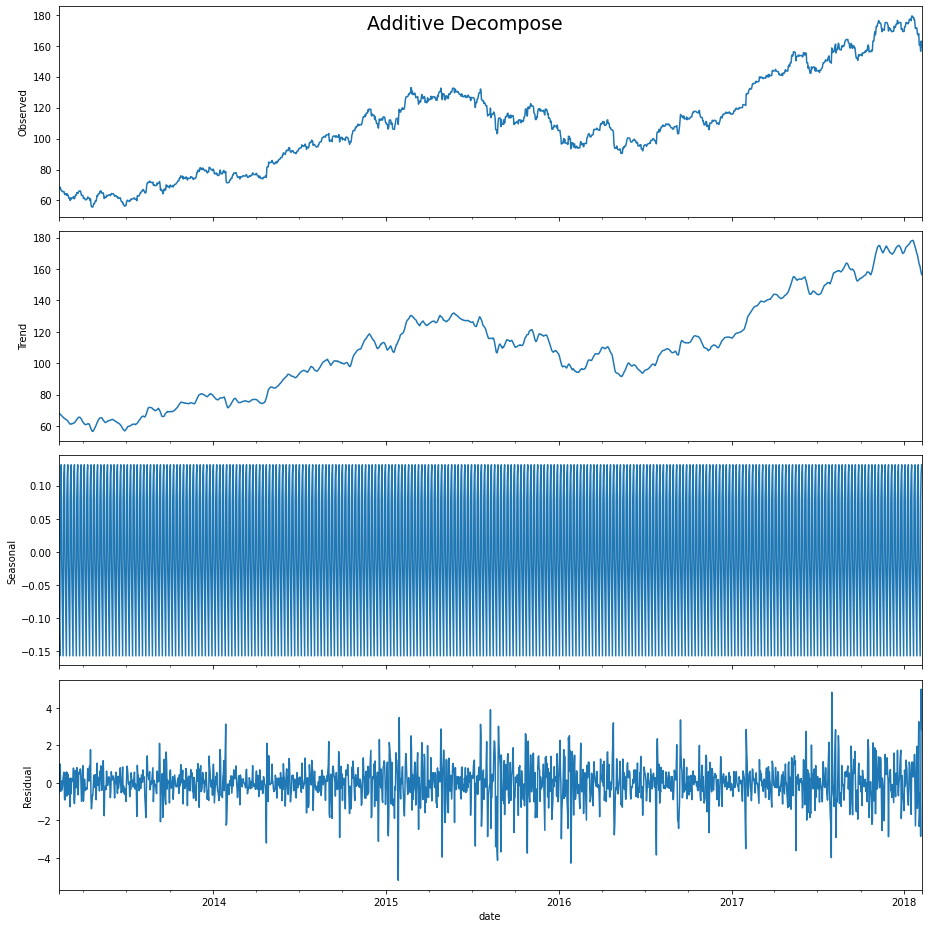

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['close'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['close'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (13,13)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=19)
result_add.plot().suptitle('Additive Decompose', fontsize=19)
plt.show()

In [ ]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df['close'])

(0.6335992133747783, True)

## Testing for stationarity

In [ ]:
X = df['close']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 #pvalues indicate ts is not stationarity ,time series is required to be made stationary

ADF Statistic: -0.663878
p-value: 0.855885
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



ACF and PACF plots

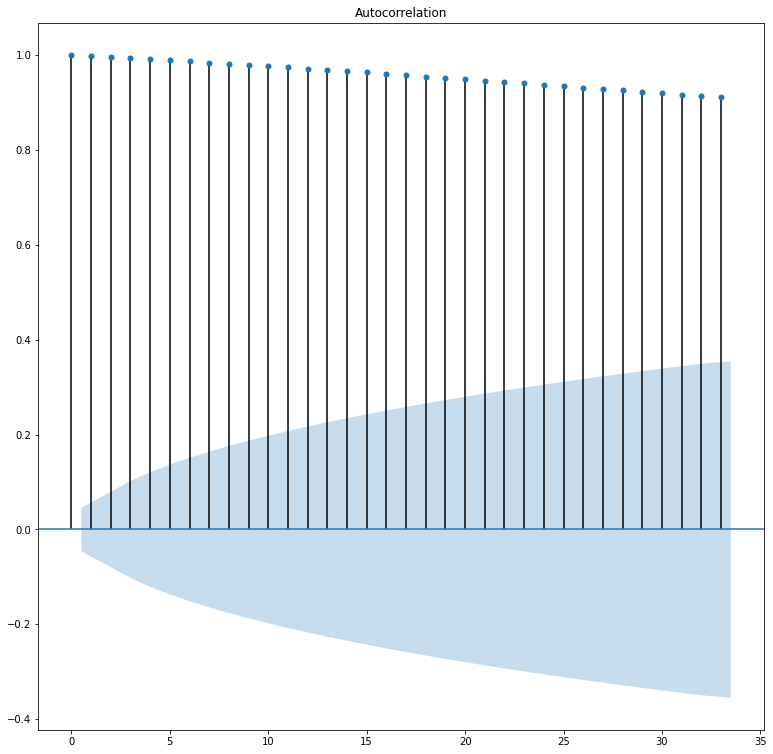

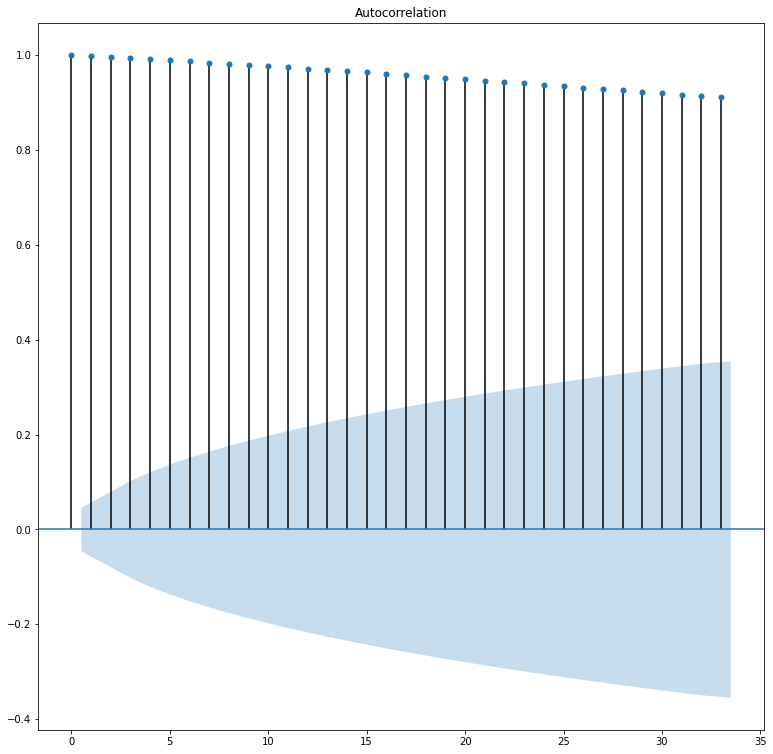

In [ ]:
plot_acf(df.close)

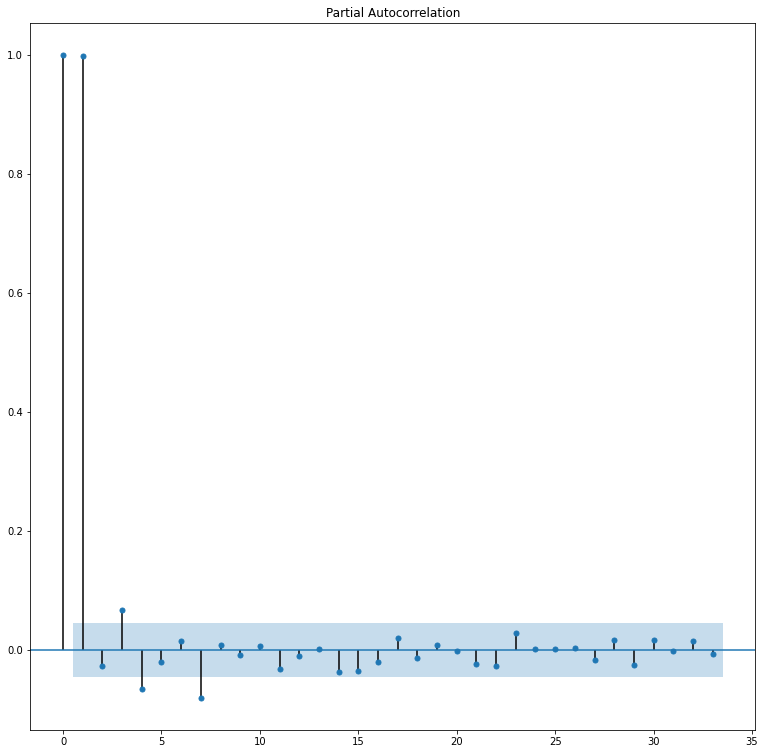

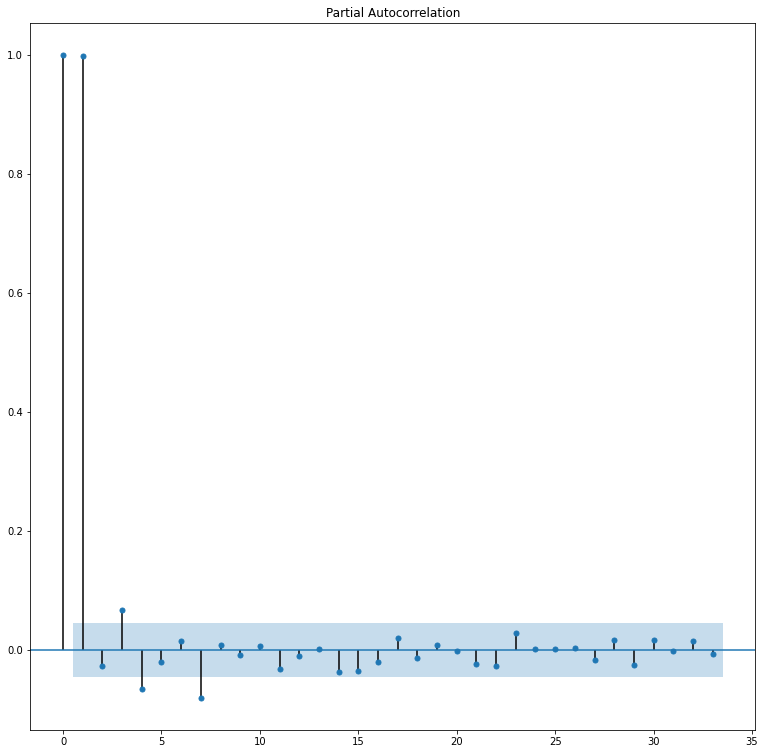

In [ ]:
plot_pacf(df.close)

## Simple Exponential Smoothing

In fit1, we explicitly provide the model with the smoothing parameter α=0.2
In fit2, we choose an α=0.6
In fit3, we use the auto-optimization that allow statsmodels to automatically find an optimized value for us. This is the recommended approach.

In [ ]:
es_df = df.copy()
train_size = int(0.75*len(df))
train = es_df[:train_size]
test = es_df[train_size:]
es_df['ES1'] = 0.0
es_df['ES2'] = 0.0
es_df['ES3'] = 0.0

In [ ]:
# Simple Exponential Smoothing
es_smooth = [0.2, 0.6, 0.9]
rmse = []
for j in [1, 2, 3]:
    history = train
    predictions = pd.DataFrame(columns=['close'])
    for i in range(0,len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level = es_smooth[j-1], optimized=False)
        temp_df = pd.DataFrame({'close': model.forecast()}, index=model.forecast().index)
        predictions = predictions.append(temp_df)
        history = history.append(test[i: i + 1])
    #     print('Predicted=%f, Expected=%f' % (df10.iloc[0,0], test.iloc[i:i+1,0]))
    for i in range(0,train_size):
        es_df['ES' + str(j)][i] = model.fittedvalues[i]
    for i in range(train_size, len(es_df)):
        es_df['ES' + str(j)][i] = predictions['close'][i - train_size]
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))

In [ ]:
es_fig = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index,
            "y": es_df.close,
            "name": "AAPL - Actual",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index[:train_size],
            "y": es_df.ES1[:train_size],
            "name": "0.2 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2 ES",
            "line": {
                "color": "Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index[train_size:],
            "y": es_df.ES1[train_size:],
            "name": "0.2 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2 ES",
            "line": {
                "color": "Light Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index[:train_size],
            "y": es_df.ES2[:train_size],
            "name": "0.6 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6 ES",
            "line": {
                "color": "Black",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index[train_size:],
            "y": es_df.ES2[train_size:],
            "name": "0.6 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6 ES",
            "line": {
                "color": "Grey",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index[:train_size],
            "y": es_df.ES3[:train_size],
            "name": "0.9 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9 ES",
            "line": {
                "color": "Green",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index[train_size:],
            "y": es_df.ES3[train_size:],
            "name": "0.9 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9 ES",
            "line": {
                "color": "Light Green",
            },
        },
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [es_df.index[len(es_df) - 261], es_df.index[len(es_df) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 600,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(es_fig)

In [ ]:
es_smooth = [0.2, 0.6, 0.9]

es_df_fitted = df.copy()
es_df_fitted['ES1'] = 0.0
es_df_fitted['ES2'] = 0.0
es_df_fitted['ES3'] = 0.0

lastdate = es_df.index[len(es_df) - 1]
index1 = []
for i in range(0, 10):
    lastdate = lastdate + timedelta(days=1)
    index1.append(lastdate)
es_df_forecast = pd.DataFrame(columns=["ES1", "ES2", "ES3"], index=index1)
es_df_forecast["ES1"] = 0.0
es_df_forecast["ES2"] = 0.0
es_df_forecast["ES3"] = 0.0

for j in [1, 2, 3]:
    es = SimpleExpSmoothing(df).fit(smoothing_level=es_smooth[j-1], optimized=False)
    es_df_fitted['ES' + str(j)] = es.fittedvalues
    es_df_forecast['ES' + str(j)] = es.forecast(10)

In [ ]:
es_fig_forecast = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df.index,
            "y": es_df.close,
            "name": "AAPL - Actual",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df_fitted.index,
            "y": es_df_fitted.ES1,
            "name": "0.2 Trained",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2 ES",
            "line": {
                "color": "Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df_forecast.index,
            "y": es_df.ES1,
            "name": "0.2 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2 ES",
            "line": {
                "color": "Light Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df_fitted.index,
            "y": es_df_fitted.ES2,
            "name": "0.6 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6 ES",
            "line": {
                "color": "Black",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df_forecast.index,
            "y": es_df_forecast.ES2,
            "name": "0.6 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6 ES",
            "line": {
                "color": "Grey",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df_fitted.index,
            "y": es_df_fitted.ES3,
            "name": "0.9 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9 ES",
            "line": {
                "color": "Green",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": es_df_forecast.index,
            "y": es_df_forecast.ES3,
            "name": "0.9 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9 ES",
            "line": {
                "color": "Light Green",
            },
        },
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [es_df_fitted.index[len(es_df_fitted) - 261], es_df_forecast.index[len(es_df_forecast) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 600,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(es_fig_forecast)

## Holt's Method


In fit1, we explicitly provide the model with the smoothing parameter α=0.8, β*=0.2.
In fit2, we use an exponential model rather than a Holt’s additive model(which is the default).
In fit3, we use a damped version of the Holt’s additive model but allow the dampening parameter ϕ to be optimized while fixing the values for α=0.8, β*=0.2.

In [ ]:
holt_df = df.copy()
train_size = int(0.75*len(df))
train = df[:train_size]
test = df[train_size:]
holt_df['Holt1'] = 0.0
holt_df['Holt2'] = 0.0
holt_df['Holt3'] = 0.0

In [ ]:
holt_smooth = [0.2, 0.6, 0.9]
holt_trend = [0.4, 0.7, 0.5]
rmse = []
for j in [1, 2, 3]:
    history = train
    predictions = pd.DataFrame(columns=['close'])
    for i in range(0,len(test)):
        model = Holt(history).fit(smoothing_level=holt_smooth[j-1], smoothing_slope=holt_trend[j-1], optimized=False)
        temp_df = pd.DataFrame({'close': model.forecast()}, index=model.forecast().index)
        predictions = predictions.append(temp_df)
        history = history.append(test[i: i + 1])
    #     print('Predicted=%f, Expected=%f' % (df10.iloc[0,0], test.iloc[i:i+1,0]))
    for i in range(0,train_size):
        holt_df['Holt' + str(j)][i] = model.fittedvalues[i]
    for i in range(train_size, len(holt_df)):
        holt_df['Holt' + str(j)][i] = predictions['close'][i - train_size]
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))

In [ ]:
holt_fig = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index,
            "y": holt_df.close,
            "name": "AAPL - Actual",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index[:train_size],
            "y": holt_df.Holt1[:train_size],
            "name": "0.2, 0.4 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4 Holt",
            "line": {
                "color": "Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index[train_size:],
            "y": holt_df.Holt1[train_size:],
            "name": "0.2, 0.4 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4 Holt",
            "line": {
                "color": "Light Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index[:train_size],
            "y": holt_df.Holt2[:train_size],
            "name": "0.6, 0.7 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7 Holt",
            "line": {
                "color": "Black",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index[train_size:],
            "y": holt_df.Holt2[train_size:],
            "name": "0.6, 0.7 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7 Holt",
            "line": {
                "color": "Grey",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index[:train_size],
            "y": holt_df.Holt3[:train_size],
            "name": "0.9, 0.5 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5 Holt",
            "line": {
                "color": "Green",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df.index[train_size:],
            "y": holt_df.Holt3[train_size:],
            "name": "0.9, 0.5 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5 Holt",
            "line": {
                "color": "Light Green",
            },
        },
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [holt_df.index[len(holt_df) - 261], holt_df.index[len(holt_df) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 600,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(holt_fig)

In [ ]:
holt_smooth = [0.2, 0.6, 0.9]
holt_trend = [0.4, 0.7, 0.5]

holt_df_fitted = df.copy()
holt_df_fitted['Holt1'] = 0.0
holt_df_fitted['Holt2'] = 0.0
holt_df_fitted['Holt3'] = 0.0

lastdate = df.index[len(df) - 1]
index1 = []
for i in range(0, 10):
    lastdate = lastdate + timedelta(days=1)
    index1.append(lastdate)
holt_df_forecast = pd.DataFrame(columns=["Holt1", "Holt2", "Holt3"], index=index1)
holt_df_forecast["Holt1"] = 0.0
holt_df_forecast["Holt2"] = 0.0
holt_df_forecast["Holt3"] = 0.0

for j in [1, 2, 3]:
    holt = Holt(df).fit(smoothing_level=holt_smooth[j-1], smoothing_slope=holt_trend[j-1], optimized=False)
    holt_df_fitted['Holt' + str(j)] = holt.fittedvalues
    holt_df_forecast['Holt' + str(j)] = holt.forecast(10)

In [ ]:
holt_fig_forecast = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": df.index,
            "y": df.close,
            "name": "AAPL - Actual",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df_fitted.index,
            "y": holt_df_fitted.Holt1,
            "name": "0.2, 0.4 Trained",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4 Holt",
            "line": {
                "color": "Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df_forecast.index,
            "y": holt_df_forecast.Holt1,
            "name": "0.2, 0.4 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4 Holt",
            "line": {
                "color": "Light Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df_fitted.index,
            "y": holt_df_fitted.Holt2,
            "name": "0.6, 0.7 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7 Holt",
            "line": {
                "color": "Black",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df_forecast.index,
            "y": holt_df_forecast.Holt2,
            "name": "0.6, 0.7 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7 Holt",
            "line": {
                "color": "Grey",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df_fitted.index,
            "y": holt_df_fitted.Holt3,
            "name": "0.9, 0.5 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5 Holt",
            "line": {
                "color": "Green",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": holt_df_forecast.index,
            "y": holt_df_forecast.Holt3,
            "name": "0.9, 0.5 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5 Holt",
            "line": {
                "color": "Light Green",
            },
        },
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [es_df_fitted.index[len(es_df_fitted) - 261], es_df_forecast.index[len(es_df_forecast) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 600,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(holt_fig_forecast)

In [ ]:
# fit4 = Holt(train_1).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
# fcast4 = fit4.forecast(12).rename("Holt's linear trend")

# fit5 = Holt(train_1, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
# fcast5 = fit5.forecast(12).rename("Exponential trend")

# fit6 = Holt(train_1, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
# fcast6 = fit6.forecast(12).rename("Additive damped trend")


# fit4.fittedvalues.plot(marker="o", color='blue')
# fcast4.plot(color='blue', marker="o", legend=True)
# fit5.fittedvalues.plot(marker="o", color='red')
# fcast5.plot(color='red', marker="o", legend=True)
# fit6.fittedvalues.plot(marker="o", color='green')
# fcast6.plot(color='green', marker="o", legend=True)

# plt.show()

In [ ]:
# print(fcast4.head(2),fcast5.head(2),fcast6.head(2))

In [ ]:
# print(np.sqrt(mean_squared_error(test_1,fcast4)))
# print(np.sqrt(mean_squared_error(test_1,fcast5)))
# print(np.sqrt(mean_squared_error(test_1,fcast6)))

## Holt Winters Model

In [ ]:
winter_df = df.copy()
train_size = int(0.75*len(df))
train = df[:train_size]
test = df[train_size:]
winter_df['Winter1'] = 0.0
winter_df['Winter2'] = 0.0
winter_df['Winter3'] = 0.0

In [ ]:
winter_smooth = [0.2, 0.6, 0.9]
winter_trend = [0.4, 0.7, 0.5]
winter_season = [0.5, 0.7, 0.6]
rmse = []
for j in [1, 2, 3]:
    history = train
    predictions = pd.DataFrame(columns=['close'])
    for i in range(0,len(test)):
        model = ExponentialSmoothing(history, seasonal_periods=365, trend='add', seasonal='add').fit(smoothing_level=winter_smooth[j-1], smoothing_slope=winter_trend[j-1], smoothing_seasonal=winter_season[j-1], optimized=False)
        temp_df = pd.DataFrame({'close': model.forecast()}, index=model.forecast().index)
        predictions = predictions.append(temp_df)
        history = history.append(test[i: i + 1])
    #     print('Predicted=%f, Expected=%f' % (df10.iloc[0,0], test.iloc[i:i+1,0]))
    for i in range(0,train_size):
        winter_df['Winter' + str(j)][i] = model.fittedvalues[i]
    for i in range(train_size, len(holt_df)):
        winter_df['Winter' + str(j)][i] = predictions['close'][i - train_size]
    rmse.append(np.sqrt(mean_squared_error(test, predictions)))

In [ ]:
winter_fig = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index,
            "y": winter_df.close,
            "name": "AAPL - Actual",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index[:train_size],
            "y": winter_df.Winter1[:train_size],
            "name": "0.2, 0.4, 0.5 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4, 0.5 Winter",
            "line": {
                "color": "Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index[train_size:],
            "y": winter_df.Winter1[train_size:],
            "name": "0.2, 0.4, 0.5 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4, 0.5 Winter",
            "line": {
                "color": "Light Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index[:train_size],
            "y": winter_df.Winter2[:train_size],
            "name": "0.6, 0.7, 0.7 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7, 0.7 Winter",
            "line": {
                "color": "Black",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index[train_size:],
            "y": winter_df.Winter2[train_size:],
            "name": "0.6, 0.7, 0.7 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7, 0.7 Winter",
            "line": {
                "color": "Grey",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index[:train_size],
            "y": winter_df.Winter3[:train_size],
            "name": "0.9, 0.5, 0.6 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5, 0.6 Winter",
            "line": {
                "color": "Green",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df.index[train_size:],
            "y": winter_df.Winter3[train_size:],
            "name": "0.9, 0.5, 0.6 Test",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5, 0.6 Winter",
            "line": {
                "color": "Light Green",
            },
        },
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [winter_df.index[len(winter_df) - 261], winter_df.index[len(winter_df) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 600,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(winter_fig)

In [ ]:
winter_smooth = [0.2, 0.6, 0.9]
winter_trend = [0.4, 0.7, 0.5]
winter_season = [0.5, 0.7, 0.6]

winter_df_fitted = df.copy()
winter_df_fitted['Winter1'] = 0.0
winter_df_fitted['Winter2'] = 0.0
winter_df_fitted['Winter3'] = 0.0

lastdate = df.index[len(df) - 1]
index1 = []
for i in range(0, 10):
    lastdate = lastdate + timedelta(days=1)
    index1.append(lastdate)
winter_df_forecast = pd.DataFrame(columns=["Winter1", "Winter2", "Winter3"], index=index1)
winter_df_forecast["Winter1"] = 0.0
winter_df_forecast["Winter2"] = 0.0
winter_df_forecast["Winter3"] = 0.0

for j in [1, 2, 3]:
    winter = ExponentialSmoothing(history, seasonal_periods=365, trend='add', seasonal='add').fit(smoothing_level=winter_smooth[j-1], smoothing_slope=winter_trend[j-1], smoothing_seasonal=winter_season[j-1], optimized=False)
    winter_df_fitted['Winter' + str(j)] = winter.fittedvalues
    winter_df_forecast['Winter' + str(j)] = winter.forecast(10)

In [ ]:
winter_fig_forecast = go.Figure(
    data=[
        {
            "type": "scatter",
            "mode": "lines",
            "x": df.index,
            "y": df.close,
            "name": "AAPL - Actual",
            "showlegend": True,
            "line": {
                "color": "Red",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df_fitted.index,
            "y": winter_df_fitted.Winter1,
            "name": "0.2, 0.4, 0.5 Trained",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4, 0.5 Winter",
            "line": {
                "color": "Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df_forecast.index,
            "y": winter_df_forecast.Winter1,
            "name": "0.2, 0.4, 0.5 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.2, 0.4, 0.5 Winter",
            "line": {
                "color": "Light Blue",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df_fitted.index,
            "y": winter_df_fitted.Winter2,
            "name": "0.6, 0.7, 0.7 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7, 0.7 Winter",
            "line": {
                "color": "Black",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df_forecast.index,
            "y": winter_df_forecast.Winter2,
            "name": "0.6, 0.7, 0.7 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.6, 0.7, 0.7 Winter",
            "line": {
                "color": "Grey",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df_fitted.index,
            "y": winter_df_fitted.Winter3,
            "name": "0.9, 0.5, 0.6 Train",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5, 0.6 Winter",
            "line": {
                "color": "Green",
            },
        },
        {
            "type": "scatter",
            "mode": "lines",
            "x": winter_df_forecast.index,
            "y": winter_df_forecast.Winter3,
            "name": "0.9, 0.5, 0.6 Forecasted",
            "showlegend": True,
            "legendgroup": "AAPL - 0.9, 0.5, 0.6 Winter",
            "line": {
                "color": "Light Green",
            },
        },
    ],
    layout={
        "xaxis": {
            "spikemode": "toaxis+across",
            "spikethickness": 1,
            "spikedash": "solid",
            "range": [winter_df_fitted.index[len(winter_df_fitted) - 261], es_df_forecast.index[len(es_df_forecast) - 1]],
            "rangeslider": {
                "visible": True,
                "thickness": 0.075
            },
            "automargin": False,
        },
        "autosize": False,
        "width": 1000,
        "height": 600,
        "yaxis": {
            "title": "Close",
            "fixedrange": False,
            "spikethickness": 1,
            "spikemode": "toaxis+across",
            "spikedash": "solid",
            "showgrid": True,
        }
    }
)
iplot(winter_fig_forecast)